In [1]:
# Build a Mock Model in PyTorch with a convolution and a reduceMean layer
import torch
import torchvision
import torch.nn as nn
import torch.onnx as torch_onnx
import numpy as np
from models.wgan import *
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
aG = torch.load('generator.pt', map_location='cpu')
aG.eval()

GoodGenerator(
  (ln1): Linear(in_features=128, out_features=8192, bias=True)
  (rb1): ResidualBlock(
    (relu1): ReLU()
    (relu2): ReLU()
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_shortcut): UpSampleConv(
      (conv): MyConvo2d(
        (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      )
      (depth_to_space): DepthToSpace()
    )
    (conv_1): UpSampleConv(
      (conv): MyConvo2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (depth_to_space): DepthToSpace()
    )
    (conv_2): MyConvo2d(
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (rb2): ResidualBlock(
    (relu1): ReLU()
    (relu2): ReLU()
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNo

In [4]:
BATCH_SIZE = 64
def generate_image(noise=None):
    if noise is None:
        noise = gen_rand_noise()

    with torch.no_grad():
    	noisev = noise 
    samples = aG(noisev)
    samples = samples.view(BATCH_SIZE, 3, 64, 64)
    samples = samples * 0.5 + 0.5
    return samples

def gen_rand_noise():
    noise = torch.randn(BATCH_SIZE, 128)
    noise = noise.to('cpu')

    return noise

def plot_batch(title, image_list):
    plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(image_list.detach().numpy(), (1,2,0)))
    plt.show()

torch.Size([3, 530, 530])
(530, 530, 3)


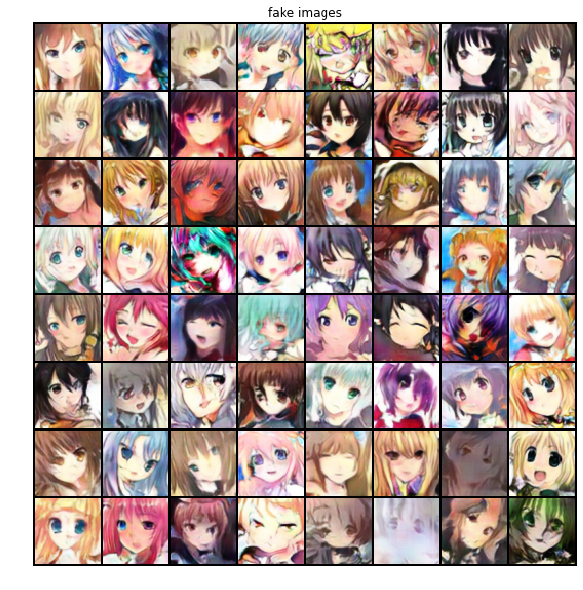

In [7]:
grid_images = torchvision.utils.make_grid(generate_image(), nrow=8, padding=2)
print(grid_images.shape)
print((np.transpose(grid_images.detach().numpy(), (1,2,0)).shape))
plot_batch('fake images', grid_images)

In [4]:
model_onnx_path = "./animefaces_generator.onnx"

# Export the model to an ONNX file
dummy_input = torch.randn(64, 128)
output = torch_onnx.export(aG, 
                          dummy_input, 
                          model_onnx_path, 
                          verbose=False)
print("Export of torch_model.onnx complete!")

/Users/allen/projects/pytorch/wgan_animefaces/models/wgan.py:50: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  output_depth = int(input_depth / self.block_size_sq)
/Users/allen/projects/pytorch/wgan_animefaces/models/wgan.py:51: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  output_width = int(input_width * self.block_size)
/Users/allen/projects/pytorch/wgan_animefaces/models/wgan.py:52: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be trea

AttributeError: 'Conv2d' object has no attribute 'padding_mode'

In [1]:
import onnx

# Load the ONNX model
model = onnx.load("./animefaces_generator.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %0[FLOAT, 64x128]\n) initializers (\n  %ln1.weight[FLOAT, 8192x128]\n  %ln1.bias[FLOAT, 8192]\n  %rb1.bn1.weight[FLOAT, 512]\n  %rb1.bn1.bias[FLOAT, 512]\n  %rb1.bn1.running_mean[FLOAT, 512]\n  %rb1.bn1.running_var[FLOAT, 512]\n  %rb1.bn1.num_batches_tracked[INT64, scalar]\n  %rb1.bn2.weight[FLOAT, 512]\n  %rb1.bn2.bias[FLOAT, 512]\n  %rb1.bn2.running_mean[FLOAT, 512]\n  %rb1.bn2.running_var[FLOAT, 512]\n  %rb1.bn2.num_batches_tracked[INT64, scalar]\n  %rb1.conv_shortcut.conv.conv.weight[FLOAT, 512x512x1x1]\n  %rb1.conv_shortcut.conv.conv.bias[FLOAT, 512]\n  %rb1.conv_1.conv.conv.weight[FLOAT, 512x512x3x3]\n  %rb1.conv_2.conv.weight[FLOAT, 512x512x3x3]\n  %rb1.conv_2.conv.bias[FLOAT, 512]\n  %rb2.bn1.weight[FLOAT, 512]\n  %rb2.bn1.bias[FLOAT, 512]\n  %rb2.bn1.running_mean[FLOAT, 512]\n  %rb2.bn1.running_var[FLOAT, 512]\n  %rb2.bn1.num_batches_tracked[INT64, scalar]\n  %rb2.bn2.weight[FLOAT, 256]\n  %rb2.bn2.bias[FLOAT, 256]\n  %rb2.bn2.running_mean[FLOAT, 2

In [2]:
from onnx_tf.backend import prepare

# to tensorflow
tf_rep = prepare(model)  # prepare tf representation
tf_rep.export_graph("./animefaces_generator_tf.pb")  # export the model

/Users/allen/projects/onnx-tensorflow/onnx_tf/common/__init__.py:87: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/allen/projects/onnx-tensorflow/onnx_tf/common/__init__.py:87: UserWarning: FrontendHandler.get_outputs_names is deprecated. It will be removed in future release. Use node.outputs instead.
  warnings.warn(message)
/Users/allen/projects/onnx-tensorflow/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op ConstantFill in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/Users/allen/projects/onnx-tensorflow/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op MeanVarianceNormalization in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [3]:
import tensorflow as tf
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants

export_dir = './saved'
graph_pb = 'animefaces_generator_tf.pb'

builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

with tf.gfile.GFile(graph_pb, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

sigs = {}

with tf.Session(graph=tf.Graph()) as sess:
    # name="" is important to ensure we don't get spurious prefixing
    tf.import_graph_def(graph_def, name="")
    g = tf.get_default_graph()
    inp = g.get_tensor_by_name("0:0")
    out = g.get_tensor_by_name("Tanh:0")

    sigs[signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY] = \
        tf.saved_model.signature_def_utils.predict_signature_def(
            {"in": inp}, {"out": out})

    builder.add_meta_graph_and_variables(sess,
                                         [tag_constants.SERVING],
                                         signature_def_map=sigs)

builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./saved/saved_model.pb


b'./saved/saved_model.pb'

In [4]:
with tf.Graph().as_default():
    graph_def = tf.GraphDef()
    with open(graph_pb, "rb") as f:
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name="")
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        #init = tf.initialize_all_variables()
        sess.run(init)

        # print all ops, check input/output tensor name.
        # uncomment it if you donnot know io tensor names.
        print('-------------ops---------------------')
        op = sess.graph.get_operations()
        for m in op:
            print(m.values())
        print('-------------ops done.---------------------')

        input_x = sess.graph.get_tensor_by_name("0:0") # input
        output = sess.graph.get_tensor_by_name('Tanh:0') # 5
        output_tf_pb = sess.run([output], feed_dict={input_x:np.random.randn(64, 128)})
        #print(output_tf_pb)

-------------ops---------------------
(<tf.Tensor 'Const:0' shape=(64,) dtype=float32>,)
(<tf.Tensor 'Const_1:0' shape=() dtype=int64>,)
(<tf.Tensor 'Const_2:0' shape=(64,) dtype=float32>,)
(<tf.Tensor 'Const_3:0' shape=(64,) dtype=float32>,)
(<tf.Tensor 'Const_4:0' shape=(64,) dtype=float32>,)
(<tf.Tensor 'Const_5:0' shape=(3,) dtype=float32>,)
(<tf.Tensor 'Const_6:0' shape=(3, 64, 3, 3) dtype=float32>,)
(<tf.Tensor 'Const_7:0' shape=(8192,) dtype=float32>,)
(<tf.Tensor 'Const_8:0' shape=(8192, 128) dtype=float32>,)
(<tf.Tensor 'Const_9:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'Const_10:0' shape=() dtype=int64>,)
(<tf.Tensor 'Const_11:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'Const_12:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'Const_13:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'Const_14:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'Const_15:0' shape=() dtype=int64>,)
(<tf.Tensor 'Const_16:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'Const_17:0' shape=(512,) dtype=float3

NameError: name 'np' is not defined

In [5]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved ./converted

/bin/sh: tensorflowjs_converter: command not found
